<a href="https://colab.research.google.com/github/happyendingddd/CRISPR_Cas9_gRNA_design/blob/main/CNN_off_target_ROC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [295]:
import tensorflow as tf

import pandas as pd
import numpy as np
from tensorflow.keras import layers
import sklearn
import matplotlib.pyplot as plt

In [296]:
# 数据导入1
file_path='/content/merge_ot_sgRNA_K562_binary.csv'
data_read=pd.read_csv(file_path,sep=',')
otSeq=np.array(data_read['OT'])
guideSeq=np.array(data_read['Target sgRNA'])
labels=np.array(data_read['Cleavage Frequency'])

In [297]:
data_read['Target sgRNA'].shape

(120,)

In [298]:
'''
# after专属代码
# 数据导入2（已经是编码形式）
num_read=guideSeq.shape[0]
seqdata_gP=np.load('/content/generated_ot_sgRNA_code_K562_positive.npy')[0:num_read-1]
seqdata_gN=np.load('/content/generated_ot_sgRNA_code_K562_negetive.npy')[0:num_read-1]
seqdata_g=np.vstack([seqdata_gP,seqdata_gN])
labels_gP=np.zeros(seqdata_gP.shape[0])+1
labels_gN=np.zeros(seqdata_gN.shape[0])
labels_g=np.r_[labels_gP,labels_gN]
labels_all=np.r_[labels,labels_g]
'''

"\n# after专属代码\n# 数据导入2（已经是编码形式）\nnum_read=guideSeq.shape[0]\nseqdata_gP=np.load('/content/generated_ot_sgRNA_code_K562_positive.npy')[0:num_read-1]\nseqdata_gN=np.load('/content/generated_ot_sgRNA_code_K562_negetive.npy')[0:num_read-1]\nseqdata_g=np.vstack([seqdata_gP,seqdata_gN])\nlabels_gP=np.zeros(seqdata_gP.shape[0])+1\nlabels_gN=np.zeros(seqdata_gN.shape[0])\nlabels_g=np.r_[labels_gP,labels_gN]\nlabels_all=np.r_[labels,labels_g]\n"

In [299]:
# 0ne_hot编码
ntmap = {'A': (1, 0, 0, 0),
         'C': (0, 1, 0, 0),
         'G': (0, 0, 1, 0),
         'T': (0, 0, 0, 1)
         }

def get_seqcode(seq):
    return list(map(lambda c: ntmap[c], seq))

def oneHotcoding(Seq):
    n=0
    for seq in Seq:
        if n==0:
            SeqcodeL=[]
        seqcode=get_seqcode(seq)
        n+=1
        SeqcodeL.append(seqcode)
        seqcode=[]
        SeqcodeA=np.array(SeqcodeL)
    return SeqcodeA

In [300]:
# OR算子编码sgRNA-DNA
def OR(a,b):
    ab=np.zeros([a.shape[0],a.shape[1]])
    for i in range(a.shape[0]):
        for j in range(a.shape[1]):
            if a[i][j] != b[i][j]:
                ab[i][j]=a[i][j]+b[i][j]
            else:
                ab[i][j]=a[i][j]
    return ab

In [301]:
# 编码
guidecode=oneHotcoding(guideSeq)
otcode=oneHotcoding(otSeq)
guide_ot_code=np.zeros((guidecode.shape[0],guidecode.shape[1],guidecode.shape[2]))
for i in range(len(guidecode)):
    guide_ot_code[i]=OR(guidecode[i],otcode[i])
seqdata=guide_ot_code

In [302]:
'''
# after专属代码
seqdata_all=np.vstack([seqdata,seqdata_g])
print(seqdata_all.shape)
'''

'\n# after专属代码\nseqdata_all=np.vstack([seqdata,seqdata_g])\nprint(seqdata_all.shape)\n'

In [303]:

# before专属代码
seqdata_all=seqdata
labels_all=labels


In [304]:
seqdata_all.shape

(120, 23, 4)

In [305]:
labels_all.shape

(120,)

In [306]:
from sklearn.model_selection import train_test_split
train_seq,test_seq,train_lab,test_lab=train_test_split(seqdata_all,labels_all,train_size = 0.6,random_state=0,stratify=labels_all)

In [307]:
val_seq=test_seq[:int(test_seq.shape[0]*0.25)];val_lab=test_lab[:int(test_seq.shape[0]*0.25)]
Ntest_seq=test_seq[int(test_seq.shape[0]*0.25)+1:];Ntest_lab=test_lab[int(test_seq.shape[0]*0.25)+1:]

In [308]:
sum(Ntest_lab)

3

In [309]:
def CNN_model():
  model = tf.keras.Sequential()
  
  model.add(layers.Conv1D(16, 3, padding='same', activation='relu', input_shape=(23,4)))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv1D(64, 3,padding='same', activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv1D(64, 3,padding='same', activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Flatten())
  model.add(layers.Dense(16, activation='relu'))
  #model.add(layers.Dense(2))
  model.add(layers.Dense(2,activation='sigmoid'))

  return model

In [310]:
model=CNN_model()
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_24 (Conv1D)           (None, 23, 16)            208       
_________________________________________________________________
batch_normalization_24 (Batc (None, 23, 16)            64        
_________________________________________________________________
leaky_re_lu_24 (LeakyReLU)   (None, 23, 16)            0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 23, 16)            0         
_________________________________________________________________
conv1d_25 (Conv1D)           (None, 23, 64)            3136      
_________________________________________________________________
batch_normalization_25 (Batc (None, 23, 64)            256       
_________________________________________________________________
leaky_re_lu_25 (LeakyReLU)   (None, 23, 64)           

In [311]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [312]:
history = model.fit(train_seq, train_lab, epochs=50, batch_size=16,
                    validation_data=(val_seq, val_lab))

Epoch 1/50
5/5 [==============================] - 1s 59ms/step - loss: 0.8413 - accuracy: 0.5995 - val_loss: 0.6157 - val_accuracy: 0.9167
Epoch 2/50
5/5 [==============================] - 0s 14ms/step - loss: 0.3113 - accuracy: 0.8987 - val_loss: 0.6091 - val_accuracy: 0.9167
Epoch 3/50
5/5 [==============================] - 0s 16ms/step - loss: 0.3664 - accuracy: 0.8817 - val_loss: 0.6477 - val_accuracy: 0.9167
Epoch 4/50
5/5 [==============================] - 0s 13ms/step - loss: 0.2687 - accuracy: 0.9172 - val_loss: 0.6982 - val_accuracy: 0.4167
Epoch 5/50
5/5 [==============================] - 0s 12ms/step - loss: 0.2142 - accuracy: 0.9329 - val_loss: 0.7664 - val_accuracy: 0.0833
Epoch 6/50
5/5 [==============================] - 0s 12ms/step - loss: 0.2221 - accuracy: 0.9103 - val_loss: 0.8412 - val_accuracy: 0.0833
Epoch 7/50
5/5 [==============================] - 0s 12ms/step - loss: 0.2393 - accuracy: 0.8788 - val_loss: 0.9145 - val_accuracy: 0.0833
Epoch 8/50
5/5 [===========

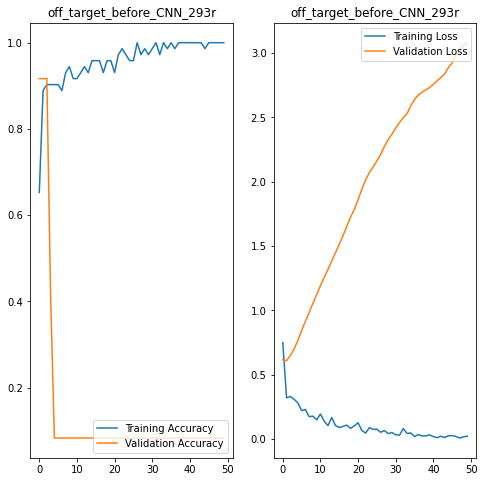

In [313]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(50)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('off_target_before_CNN_293r')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('off_target_before_CNN_293r')
plt.show()

In [314]:
test_loss, test_acc = model.evaluate(Ntest_seq, Ntest_lab, verbose=2)

2/2 - 0s - loss: 2.8335 - accuracy: 0.0857


In [315]:
pred_pro=model.predict(Ntest_seq) #计算概率

In [316]:
pred_pro.shape

(35, 2)

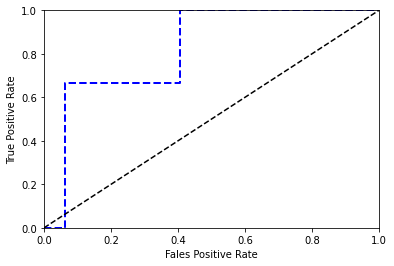

In [317]:
# ROC曲线（假正类率(fpr)/真正类率(tpr)）
from sklearn.metrics import roc_curve
fpr , tpr , thresholds = roc_curve(Ntest_lab,pred_pro[:,1])  # 计算多种阈值的TPR和FPR


def plot_roc_curve(fpr,tpr,label=None):
    plt.plot(fpr,tpr,'b--',linewidth=2,label=label)
    plt.plot([0,1],[0,1],'k--')
    plt.axis([0,1,0,1])
    plt.xlabel('Fales Positive Rate')
    plt.ylabel('True Positive Rate')


plot_roc_curve(fpr,tpr)
plt.show()

In [319]:
# ROC曲线下面积AUC
from sklearn.metrics import roc_auc_score
AUC=str(roc_auc_score(Ntest_lab,pred_pro[:,1]))

In [320]:
AUC

'0.8229166666666666'

In [321]:
listnew=[list(fpr),list(tpr)]
listnew[0]

[0.0, 0.03125, 0.0625, 0.0625, 0.40625, 0.40625, 0.90625, 0.96875, 1.0]

In [322]:
def savedata2D(list1,filepath,test_acc,AUC):
    output = open(filepath,'w+',encoding='utf-8')
    for i in range(len(list1)):
        for j in range(len(list1[i])):
                output.write(str(list1[i][j]))    
                output.write('\t')   
        output.write('\n')
    #output.write(AUC)
    #output.write('\n')
    #output.write(str(test_acc))
    #output.write('\n')
    output.close()

In [355]:
fp1='/content/data_ROC_293r_after.txt'
fp2='/content/data_ROC_293r_before.txt'
fp3='/content/data_ROC_K562_after.txt'
fp4='/content/data_ROC_K562_before.txt'


In [356]:
listA=np.loadtxt(fp1)
listB=np.loadtxt(fp2)
listC=np.loadtxt(fp3)
listD=np.loadtxt(fp4)

In [357]:
# 绘制前后变化
def plot_roc_curve2(fpr1,tpr1,fpr2,tpr2,label1,label2,title):
    plt.plot(fpr1,tpr1,'r--',linewidth=2,label=label1)
    plt.plot(fpr2,tpr2,'g--',linewidth=2,label=label2)
    plt.plot([0,1],[0,1],'k--')
    plt.axis([0,1,0,1])
    plt.xlabel('Fales Positive Rate')
    plt.ylabel('True Positive Rate')

    plt.legend(loc='upper right')
    plt.title(title)

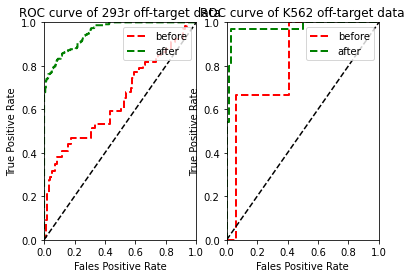

In [359]:
plt.subplot(1, 2, 1)
title1='ROC curve of 293r off-target data'
plot_roc_curve2(listB[0],listB[1],listA[0],listA[1],'before','after',title1)
plt.subplot(1, 2, 2)
title2='ROC curve of K562 off-target data'
plot_roc_curve2(listD[0],listD[1],listC[0],listC[1],'before','after',title2)
plt.show()

In [325]:
print(test_acc)

0.08571428805589676


In [326]:
# 保存模型
#model.save('/content/model_trained_before_K562_cnn.h5') 

In [327]:
# 加载模型，同时加载了模型的结构、权重等信息
#loaded_model = tf.keras.models.load_model('/content/model_trained_before_K562_cnn.h5')